# Capstone project - Car accident Severity (Week 2)

### Applied Data Science Capstone by IBM/Coursera

## Table of Contents
* [Introduction](#introduction)
* [Data Preparation](#data)
* [Exploratory Analysis](#analysis)
* [Machine Learning](#machine)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)


## Introduction <a name="introduction"></a>

In this project we will attemp to create a machine learning model which can predict the severity of a car accident. The targeted audience of this study are the emergency response services **(ERS)** as well as urban planners. The goal is to aid them in creating optimal strategies for resource allocation on a daily basis.

However, these two groups require somewhat different information to formulate their strategies. Additionally, we aim to create a generally applicable model, therefore any specifics of the accidents (people in cars involved in the crash, driver under the influence or not, cyclists or pederstrians involved, etc.) cannot be included in our model. The ERS have to plan on a daily basis, therefore they will require ***external conditions*** such as weather, lighting and road conditions, time of day, etc. The urban planners on the other hand require ***locational data*** such as address types, junction types, district traffic infrastructure development levels, lighting conditions, etc.

We will clean and process the data so that we can train a number of machine learning models using the aforementioned features. The models will then be evaluated and the best one will be chosen. 

## Data Preparation <a name="data"></a>

The data source that we will be using in this project is the Seattle city Collisions with records from 2004 to present date. It is provided by SPD and recorded by Traffic Records. It contains all the information that we will need to train our model.

External factors:
* WEATHER - weather state at the time of the collison
* ROADCOND - the condition of the road at the time of the collision
* LIGHTCOND - the lighting conditions at the location where the collision occured
* INCDTTM - the date and time when the collision occured


Urban configurations:
* JUNCTIONTYPE - the type of junction where the collision occured
* ADDRTYPE - the type of location where the collision occured

Lastly, since we are trying to predict the severity of accidents, our target varible will be the **SEVERITYCODE** column.

### Data Cleaning

First, we need to import all the necessary modules for the rest of the project

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
pd.set_option('display.max_columns', None) # Display all columns

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, jaccard_score, log_loss
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

from scipy.stats import chi2_contingency
from scipy.stats import chi2
import scipy.optimize as opt

Then we read the dataset into a dataframe using ```read_csv()``` from the pandas module.

In [2]:
body = open("Data-Collisions.csv")
df_data_1 = pd.read_csv(body)

C:\Users\Me\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
print(df_data_1.shape)

(194673, 38)


Using the metadata as well as examining the dataframe we can see that a lot of columns stand for codes or ID keys that are used by the governement groups for their own analysis. These will not be of any use to us so we can safely drop those columns.

In [4]:
df = df_data_1.drop(["X","Y","OBJECTID","INCKEY","COLDETKEY","REPORTNO","INTKEY","EXCEPTRSNCODE","SDOT_COLCODE","SDOTCOLNUM","ST_COLCODE","SEGLANEKEY","CROSSWALKKEY"],axis=1)

Excluding the feature columns specified in [Data Preparation](#data), the left over feautres describe collision specifics or contain information that is irrelevant to us. We can therefore ignore those columns and drop the missing value rows out of the features we are interested in.

In [5]:
df.drop(["ï»¿SEVERITYCODE"],axis=1,inplace=True) # drop since it is a duplicate column

df = df.dropna(axis=0,subset=["WEATHER","ROADCOND","LIGHTCOND","ADDRTYPE","JUNCTIONTYPE"])

In [6]:
# Define Values function just to save time and make printing easier
def Values(df,column=None,normal=False):
    '''Function to return the value counts of the specified column as pandas series
    
    column: str, name of column, default = None
        if left as None, it will print the value counts of all columns.
        
    normal:bool, True or False, default = False
        if True, will print the normalised value counts. '''
    
    if column==None:
        for i in df.columns:
            print(df[str(i)].value_counts(normalize=normal),"\n"*2)
    else:
        return df[str(column)].value_counts(normalize=normal)

We now need to look at the features which we are interested in. Use the ```Values()``` function.

In [7]:
df_features= df[["WEATHER","ROADCOND","LIGHTCOND","ADDRTYPE","JUNCTIONTYPE"]]
Values(df_features)

Clear                       109065
Raining                      32649
Overcast                     27189
Unknown                      11637
Snowing                        881
Other                          746
Fog/Smog/Smoke                 556
Sleet/Hail/Freezing Rain       112
Blowing Sand/Dirt               49
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64 


Dry               122159
Wet                46720
Unknown            11521
Ice                 1178
Snow/Slush           978
Other                123
Standing Water       108
Sand/Mud/Dirt         67
Oil                   60
Name: ROADCOND, dtype: int64 


Daylight                    113850
Dark - Street Lights On      47550
Unknown                      10448
Dusk                          5772
Dawn                          2454
Dark - No Street Lights       1462
Dark - Street Lights Off      1157
Other                          210
Dark - Unknown Lighting         11
Name: LIGHTC

Clearly, all those features contain only categorical data. However, all the data is in string format. This means that we have to encode the data so that it can be later used by our machine learning models. For this task we will use the ```LabelEncoder()``` from ```sklearn.preprocessing``` module.

In [8]:
df_test = df[:] # create a copy of the cleaned dataframe
                # we will perform the encoding on this copy in order to have
                # two different dataframes, one encoded and one not.

le_weather = LabelEncoder()
le_road = LabelEncoder()
le_light = LabelEncoder()
le_junc = LabelEncoder()
le_addr = LabelEncoder()

# Create empty lists and fill them with the names of the
# categorical values of each feature column
lst_weather = []
lst_road = []
lst_light = []
lst_junc = []
lst_addr = []

lst_weather = list(df_test.WEATHER.unique())
lst_road = list(df_test.ROADCOND.unique())
lst_light = list(df_test.LIGHTCOND.unique())
lst_junc = list(df_test.JUNCTIONTYPE.unique())
lst_addr = list(df_test.ADDRTYPE.unique())

# Use the unique values lists and fit them to the Label Encoders
le_weather.fit(lst_weather)
le_road.fit(lst_road)
le_light.fit(lst_light)
le_junc.fit(lst_junc)
le_addr.fit(lst_addr)

# Lastly replace each column with the encoded columns
df_test["WEATHER"] = le_weather.transform(df_test["WEATHER"])
df_test["ROADCOND"] = le_road.transform(df_test["ROADCOND"])
df_test["LIGHTCOND"] = le_light.transform(df_test["LIGHTCOND"])
df_test["JUNCTIONTYPE"] = le_junc.transform(df_test["JUNCTIONTYPE"])
df_test["ADDRTYPE"] = le_addr.transform(df_test["ADDRTYPE"])

# reset the index to account for the previous dropping
# of missing value rows
df_test.reset_index(inplace=True,drop=True)

In [9]:
df_test.head()

,STATUS,ADDRTYPE,LOCATION,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,ST_COLDESC,HITPARKEDCAR
0,Matched,2,5TH AVE NE AND NE 103RD ST,NaN,2,Injury Collision,Angles,2,0,0,2,2013/03/27 00:00:00+00,3/27/2013 2:54:00 PM,1,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,4,8,5,NaN,NaN,Entering at angle,N
1,Matched,1,AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,2006/12/20 00:00:00+00,12/20/2006 6:55:00 PM,4,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ...",NaN,0,6,8,2,NaN,NaN,From same direction - both going straight - bo...,N
2,Matched,1,4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST,NaN,1,Property Damage Only Collision,Parked Car,4,0,0,3,2004/11/18 00:00:00+00,11/18/2004 10:20:00 AM,4,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,0,4,0,5,NaN,NaN,One parked--one moving,N
3,Matched,1,2ND AVE BETWEEN MARION ST AND MADISON ST,NaN,1,Property Damage Only Collision,Other,3,0,0,3,2013/03/29 00:00:00+00,3/29/2013 9:26:00 AM,4,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,1,0,5,NaN,NaN,From same direction - all others,N
4,Matched,2,SWIFT AVE S AND SWIFT AV OFF RP,NaN,2,Injury Collision,Angles,2,0,0,2,2004/01/28 00:00:00+00,1/28/2004 8:04:00 AM,1,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,0,6,8,5,NaN,NaN,Entering at angle,N


## Exploratory Data Analysis <a name="analysis"></a>

We now turn our attention to the target variable in this project. We are interested in predicting the severity of accidents therefore we need to examine the SEVERITYCODE column.

In [10]:
Values(df,"SEVERITYCODE")

1    126276
2     56638
Name: SEVERITYCODE, dtype: int64

In [11]:
Values(df,"SEVERITYCODE",normal=True)

1    0.690357
2    0.309643
Name: SEVERITYCODE, dtype: float64

First and foremost, we clearly see that there are only 2 severity types : 1 - property damage and 2 - injury, meaning that this is a binary classification problem.

Second, we see that class 1 severity is substantially more abundant in the dataset. There are downsides if a model is trained on an unbalanced dataset such as this one. For example, the model could predict class 1 with high accuracy but have very low accuracy when predicting class 2. Therefore, we want to balance the data. Since, we have ~180000 entries we can safely downsample the majority class, or in this case severity class 1. We can do this using ```resample()``` from ```sklearn.utils```. 

In [12]:
#DOWNSAMPLING
def Downsample(df):
    #seperate into majority and minority class dataframes
    df_majority = df[df.SEVERITYCODE==1]
    df_minority = df[df.SEVERITYCODE==2]

    #downsample with sklearn.util's resample
    df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority), # majority needs to match minority class
                                 random_state=123)

    # Concatenate the the minority and the downsampled majority dataframes
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])
    
    # Shuffle the concatenated dataframe since it is currently sorted by SEVERITYCODE
    df_downsampled = df_downsampled.sample(frac=1).reset_index(drop=True)
    
    #Check if the dataset is now balanced
    if np.array(Values(df_downsampled,"SEVERITYCODE"))[0] == np.array(Values(df_downsampled,"SEVERITYCODE"))[1]:
        print("Downsampled dataset is balanced with {} entries for SEVERITYCODE 1 & 2".format(np.array(Values(df_downsampled,"SEVERITYCODE"))[0]))
    
    return df_downsampled

df_downsampled = Downsample(df_test) # Encoded dataframe
df_downsampled_ne = Downsample(df) # Not Encoded dataframe

Downsampled dataset is balanced with 56638 entries for SEVERITYCODE 1 & 2
Downsampled dataset is balanced with 56638 entries for SEVERITYCODE 1 & 2


Great! Our downsampled dataset now contains a total of 113276 entries of which exactly half are class 1 and the rest are class 2 severity.

### Feature Analysis <a name = "feature"></a>

To further improve our undestanding of the selected feature set, we can plot the distributions of the feature's counts for each severity class. This type of histogram will show us more clearly the relationship between the features and the target variable. This can be done easily using the ```seaborn``` module and in particular, using the ```histplot()``` function.

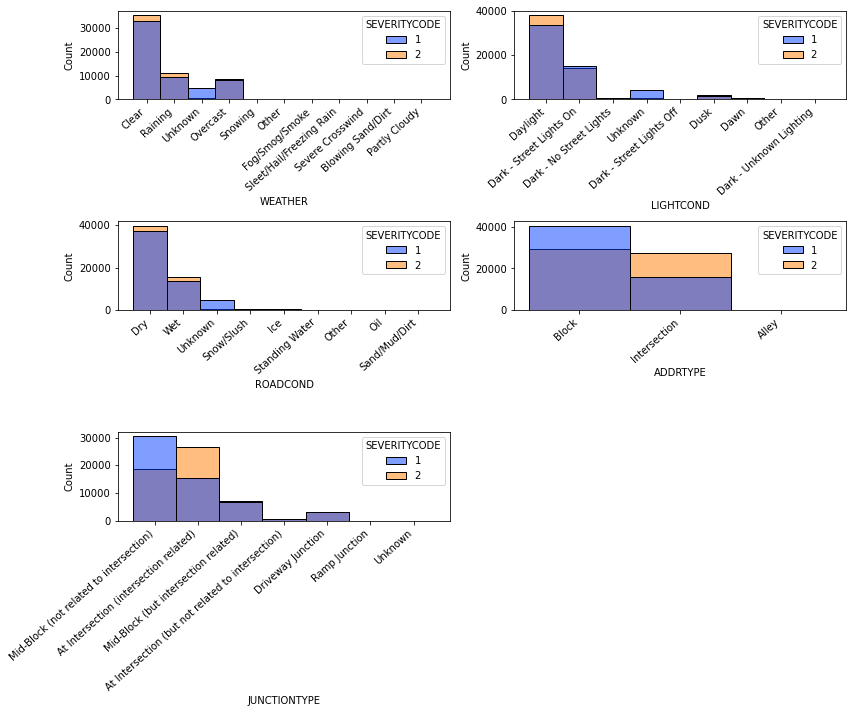

In [13]:
# Create 6 subplots for the 5 features
# One subplot needs to be removed
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(12,10)) 
axes_list = (ax1,ax2,ax3,ax4,ax5) 
features = ["WEATHER","LIGHTCOND","ROADCOND","ADDRTYPE","JUNCTIONTYPE"]

# Iterate over the feature names and subplots and plot a histogram on each one
for ft,axes in zip(features,axes_list):
    plt.setp(axes.get_xticklabels(), rotation=42, horizontalalignment='right')
    sns.histplot(data=df_downsampled_ne,x=ft, hue="SEVERITYCODE",palette="bright",ax=axes)

# Remove last subplot and fix the spacing using tight_layout()
fig.delaxes(ax6)
plt.tight_layout()

The differences distributions clearly show us how good each feature is at classifying the target variable . For example, **JUNCTIONTYPE** has the clearest distribtion distinction. We can see that for the **JUNCTIONTYPE** "At intersection (intersection related)" the count for severity class 2 (orange) cases is much higher than the severity class 1 (blue). On the other hand, at "Mid-Block (not related to intersection)" the count for severity class 1 is much higher. This difference means that **JUNCTIONTYPE** can be a good classifier for the severity of an accident.

Similarly, we can also see which features have little classification strength, e.g. have very similar distributions. **WEATHER** and **ROADCOND** are exactly like that. Their distributions are nearly identical. This could be owed to the fact that they convey almost entirely the same information. If the weather is recorded as "Raining" or "Overcast" there is an exteremly high probability that road condition is "Wet". Thus, we can drop one feature out as it is not needed. However, to decide which one should be dropped we need calculate their importances ([Feature Importance](#importance)) using the ```SelectFromModel()``` from ```sklearn.feature_selection```.

Before we perform feature selection calculations, we need to confirm that our target variable is in fact dependent on the feature set. This is done using a $\chi^2$ contingency test which is part of the ```scipy.stats``` module.

In [14]:
def cont_table(df,column,column2):
    '''Function to create a contingency table
    
    df: pandas DataFrame containing the features and the target variable
    column: str, Name of the feature column
    column2: str, Name of the target column'''
    
    new_df = pd.crosstab(df[column2], df[column]).reset_index().rename_axis('',axis='columns')
    new_df.set_index(column2,inplace=True)
    return new_df

In [15]:
features = ["JUNCTIONTYPE","WEATHER","ADDRTYPE","ROADCOND","LIGHTCOND","STATUS"] # STATUS is included as a benchmark
def P_Stat_test(df,features,test_feature):
    '''Function which performs the chi squared contingency test
    
    df: pandas DataFrame
    features: list, List of all the feature column names
    test_feature: str, Name of the target column'''
    
    for col in features:
        table = cont_table(df,col,test_feature) # create a contingency table for each feature
        print("%s" % col)
        stat, p, dof, expected = chi2_contingency(table) # calculate the chi2 test statistics
        print('dof=%d' % dof)
        print("EXPECTED:",expected,"\n")

        # interpret test-statistic
        prob = 0.95 # confidence level
        critical = chi2.ppf(prob, dof) # Critical value
        print('||probability=%.3f, critical=%.3f, stat=%.3f||' % (prob, critical, stat))

        if abs(stat) >= critical:
            print('||Dependent (reject H0)||')
        else:
            print('||Independent (fail to reject H0)||')

        # interpret p-value
        alpha = 1.0 - prob # Alpha = Significance
        print('||significance=%.3f, p=%.3f||' % (alpha, p))
        if p <= alpha:
            print('||Dependent (reject H0)||',"\n"*2)
        else:
            print('||Independent (fail to reject H0)||','\n'*2)
P_Stat_test(df_downsampled,features,"SEVERITYCODE")

JUNCTIONTYPE
dof=6
EXPECTED: [[6.25500e+02 2.10550e+04 3.23950e+03 7.02400e+03 2.46425e+04 5.10000e+01
  5.00000e-01]
 [6.25500e+02 2.10550e+04 3.23950e+03 7.02400e+03 2.46425e+04 5.10000e+01
  5.00000e-01]] 

||probability=0.950, critical=12.592, stat=5783.051||
||Dependent (reject H0)||
||significance=0.050, p=0.000||
||Dependent (reject H0)|| 


WEATHER
dof=10
EXPECTED: [[1.35000e+01 3.43035e+04 1.80000e+02 1.98500e+02 8.50550e+03 1.50000e+00
  1.03510e+04 6.00000e+00 3.25000e+01 2.39000e+02 2.80700e+03]
 [1.35000e+01 3.43035e+04 1.80000e+02 1.98500e+02 8.50550e+03 1.50000e+00
  1.03510e+04 6.00000e+00 3.25000e+01 2.39000e+02 2.80700e+03]] 

||probability=0.950, critical=18.307, stat=3282.385||
||Dependent (reject H0)||
||significance=0.050, p=0.000||
||Dependent (reject H0)|| 


ADDRTYPE
dof=2
EXPECTED: [[   59.5 34886.5 21692. ]
 [   59.5 34886.5 21692. ]] 

||probability=0.950, critical=5.991, stat=4806.838||
||Dependent (reject H0)||
||significance=0.050, p=0.000||
||Dependent (

Superb! All of our features pass the $\chi^2$ test with P-values $p<0.001$ meaning that the result is statistically significant. The last test on the **STATUS** column is included as a benchmark. Let's see the unique value counts in **STATUS**:

In [16]:
Values(df_downsampled,"STATUS")

Matched      113275
Unmatched         1
Name: STATUS, dtype: int64

Obviously, the target variable is not dependent on status, firstly because it has nothing to do with the collision but also because the value count shows that 113275 out of 113276 entries were labled as "Matched". The $\chi^2$  test shows very clearly that the target variable is independent with a P-value of $ p = 1.000 $. Thus, there is 0% probability that the two are related in any way

### Relationship between date and time and the severity class

As we stated [Data Preparation](#data), the date and time column **INCDTTM** can also be considered as a feature. However, we are not interested in the exact date the collisions occured but rather components of the date and time such as the hour, calendar day, month or even year. We will create a histogram of each of these components with respect to both severity classes and analyse the distributions. This process is exactly the same as the one carried out in [Feature Analysis](#feature).

In [17]:
df_downsampled["INCDTTM"] = pd.to_datetime(df['INCDTTM']) # Create DateTime object from the date&time column
df_downsampled.dropna(axis=0,subset=["INCDTTM"],inplace=True) # drop missing value rows

<AxesSubplot:title={'center':'Number of accidents per year'}, xlabel='INCDTTM', ylabel='Count'>

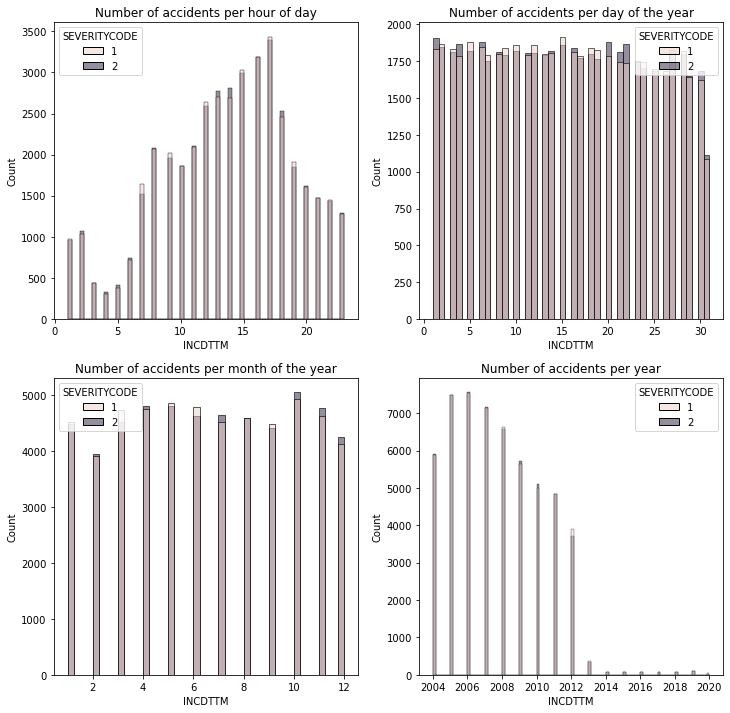

In [18]:
df_hist_hours = df_downsampled.set_index('INCDTTM', drop=False) # Make the date and time the index as it allows for easier plotting with seaborn
df_downsampled["hours"] = df_hist_hours.index.hour

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(12,12)) # create 4 subplots for the hours, calendar days, months and years

ax1.set_title("Number of accidents per hour of day")
ax2.set_title("Number of accidents per day of the year")
ax3.set_title("Number of accidents per month of the year")
ax4.set_title("Number of accidents per year")

excluded = df_hist_hours[df_hist_hours.index.hour != 0] 
# There is an anomalous amount of counts at the midnight mark, therefore we will exclude
# this is most likely caused by negligent record keeping

sns.histplot(data=excluded,x=excluded.index.hour,hue="SEVERITYCODE",ax=ax1)
sns.histplot(data=df_hist_hours,x=df_hist_hours.index.day, hue="SEVERITYCODE",ax=ax2)
sns.histplot(data=df_hist_hours,x=df_hist_hours.index.month, hue="SEVERITYCODE",ax=ax3)
sns.histplot(data=df_hist_hours,x=df_hist_hours.index.year, hue="SEVERITYCODE",ax=ax4)

The date & time graphs show us that **INCDTTM** will not perform well for our goal of preditcting the severity of the accident and as such it will not be used as a feature in the final model training. This is because, again, the distributions of both the severity classes match almost exactly. They are nearly indistinguishable and will therefore not perform well as classification features. The hour histogram (top left) resembles a Poisson or a Binomial distribution. It will be better suited for predicting the overall probability of an accident happening at a given hour.

### Feature Importance <a name="importance"></a>

The last step of the exploratory data analysis is the feature importance analysis as mentioned earlier. We have already explored the distributions of all the features that we chose for our model. In the [Feature Analysis](#feature) section we showed the distributions of each feature with respect to the severity classes. Infering from these distributions, we can predict that the most important features will be the ones with the biggest classification capabilities. Namely, that will be **JUNCTIONTYPE** and **ADDRTYPE** and the weakest should be **WEATHER** or **ROADCOND**.

In [19]:
# Define our feature set and target variable
y = np.asarray(df_downsampled["SEVERITYCODE"])
X = np.asarray(df_downsampled[["ADDRTYPE","WEATHER","LIGHTCOND","JUNCTIONTYPE","ROADCOND"]])

# use StandardScaler to normalise the data
# This allows it to be more accurately used by the machine learning models when fitting
X = preprocessing.StandardScaler().fit(X).transform(X) 


Feature ranking:
1. feature 3 (0.291246)
2. feature 0 (0.261777)
3. feature 1 (0.174745)
4. feature 2 (0.173072)
5. feature 4 (0.099160)


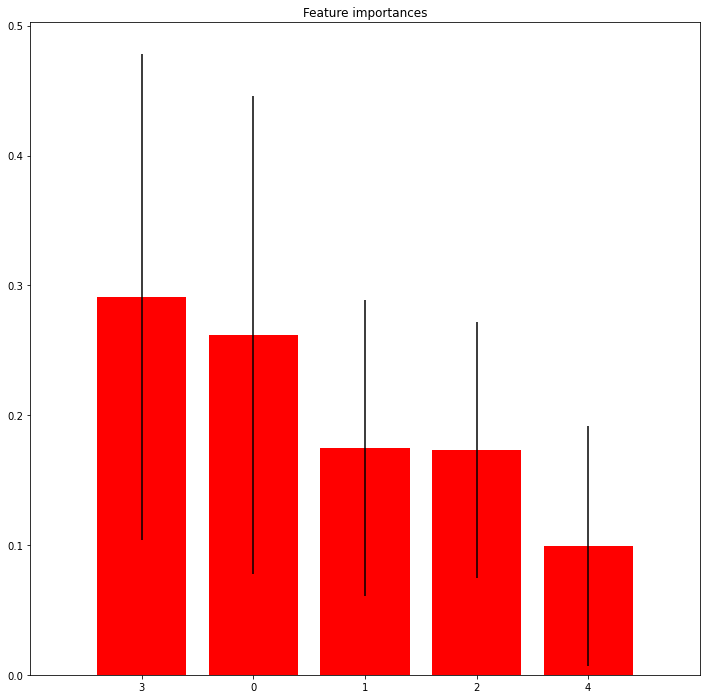

KEY: 0 - ADDRTYPE | 1 - WEATHER | 2-LIGHTCOND | 3-JUNCTIONTYPE | 4 - ROADCOND


In [20]:
#FEATURE SELECTION CHECK
cl = ExtraTreesClassifier(n_estimators=250,random_state=0) # use the extra-random tree classifier
cl.fit(X,y)

importances = cl.feature_importances_ # extract the feature importances
std = np.std([tree.feature_importances_ for tree in cl.estimators_],axis=0) # calculate the standard deviations for each imporantace
indices = np.argsort(importances)[::-1] # get the indicies of each importance to use in the ranking

print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()
print("KEY: 0 - ADDRTYPE | 1 - WEATHER | 2-LIGHTCOND | 3-JUNCTIONTYPE | 4 - ROADCOND")

The feature importance plot shows exactly the predicted behaviour. The strongest classifiers **JUNCTIONTYPE** and **ADDRTYPE** have been given the highest importance and **ROADCOND** has the lowest. **WEATHER** has similar importance to **LIGHTCOND**. The reason why **ROADCOND** has the lowest importance, even though its distribution is almost identical to that of **WEATHER**, is probably due to **WEATHER** having a maximum lower by around 10000 counts. Therefore, its percentage differences between the two distributions are higher than those in **ROADCOND**.

Finally, we will drop the **ROADCOND** feature due to its low importance.

## Machine learning <a name="machine"></a>

We are now left with a feature set made of the top 4 most important features - **JUNCTIONTYPE, ADDRTYPE, WEATHER and LIGHTCOND**. We can begin training our models, but before we do that we need to examine the effect the test size has on the accuracy of the a model. For this we will use ```LogisticRegression()``` as well as the ```RandomForestClassifier()``` modules from ```sklearn```. For the splitting we will be using the ```train_test_split()```. We will choose the *Accuracy score and Area Under ROC (AUROC)* as our evaluation metrics and plot their variance with different test sizes. Two different models are used in this test in order to see how much of a difference there might be in performance for different type of classifiers, if any.

In [21]:
# Re-define our feature set, without ROADCOND
X = np.asarray(df_downsampled[["ADDRTYPE","WEATHER","LIGHTCOND","JUNCTIONTYPE"]])

# Use StandardScaler to normalise the data
X = preprocessing.StandardScaler().fit(X).transform(X) 


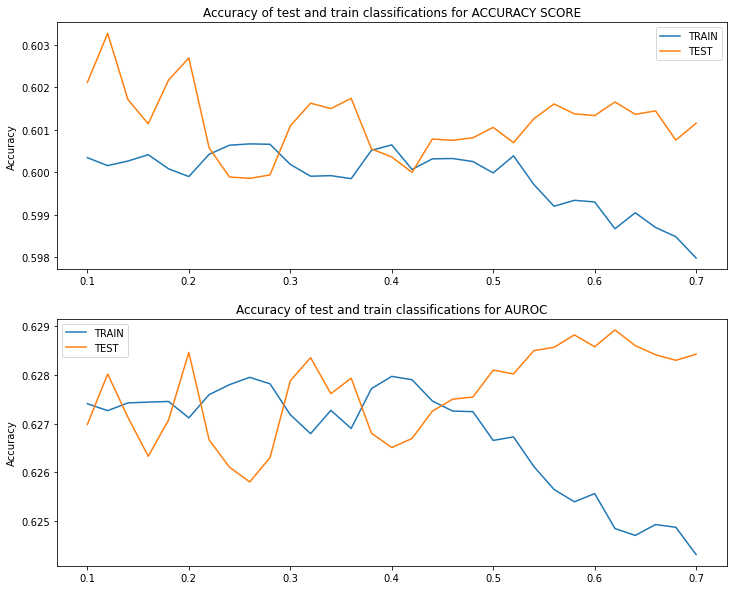

In [23]:
#LOGISTIC REGRESSION BASED

# The fractions of the data which will be used as test data when splitting
# the data
test_sizes = np.arange(0.1,0.72,0.02) 

# Dictionaries to keep the accuracy scores for each test size
acc_scores_J = {"TEST_SIZE": test_sizes} 
acc_scores_AUROC= {"TEST_SIZE": test_sizes}

#lists for the accuracy scores
test_scores = []
train_scores = []

#lists of the scores for the AUROC test
test_scores_auroc = []
train_scores_auroc = []

for i in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=i, random_state=5) # split the data into train and test
    LR = LogisticRegression()
    clf_ds = LR.fit(X_train, y_train) # train the model
    
    # Make predictions with the model
    y_pred_train =clf_ds.predict(X_train)
    y_pred_test = clf_ds.predict(X_test)
    
    # AUROC uses probabilities instead of the actual predicitons
    # Thus, we have to use the predict_proba(X) function
    y_test_prob = clf_ds.predict_proba(X_test)
    y_train_prob = clf_ds.predict_proba(X_train)
    
    # We need to keep only the positive classes for the AUROC test
    y_test_prob = [p[1] for p in y_test_prob]
    y_train_prob = [p[1] for p in y_train_prob]
    
    test_scores.append(accuracy_score(y_test,y_pred_test))
    train_scores.append(accuracy_score(y_train,y_pred_train))
    test_scores_auroc.append(roc_auc_score(y_test, y_test_prob))
    train_scores_auroc.append(roc_auc_score(y_train, y_train_prob))
    
# Populate the accuracy scores dictionaries
acc_scores_J["TRAIN"] = train_scores
acc_scores_J["TEST"] = test_scores

acc_scores_AUROC["TRAIN"] = train_scores_auroc
acc_scores_AUROC["TEST"] = test_scores_auroc

#Use the dictionaries to create dataframes
df_acc_auroc = pd.DataFrame(acc_scores_AUROC)
df_acc_auroc.set_index("TEST_SIZE",inplace=True)

df_acc = pd.DataFrame(acc_scores_J)
df_acc.set_index("TEST_SIZE",inplace=True)

# Accuracy
fig, ((ax1,ax2)) = plt.subplots(2,1,figsize=(12,10))
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy of test and train classifications for ACCURACY SCORE')
ax1.plot(df_acc.index.values, df_acc["TRAIN"],label='TRAIN')
ax1.plot(df_acc.index.values, df_acc["TEST"],label='TEST')
ax1.legend()

# AUROC
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy of test and train classifications for AUROC")
ax2.plot(df_acc_auroc.index.values,df_acc_auroc["TRAIN"],label='TRAIN')
ax2.plot(df_acc_auroc.index.values, df_acc_auroc["TEST"],label='TEST')
ax2.legend()

plt.show()

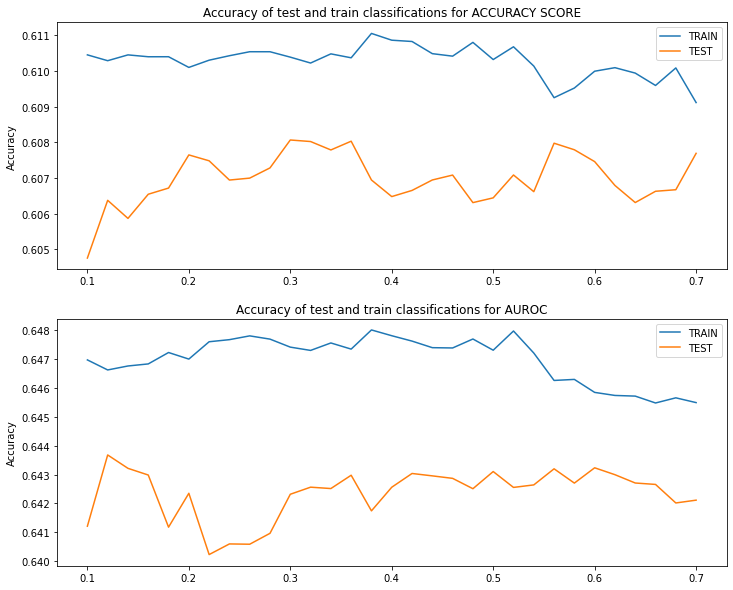

In [24]:
# RANDOM FOREST CLASSIFIER
# Absolutely the same process as the Logistic Regression test

test_scores = []
train_scores = []

test_scores_auroc = []
train_scores_auroc = []

acc_scores_J = {"TEST_SIZE": test_sizes}
acc_scores_AUROC= {"TEST_SIZE": test_sizes}

for i in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=i, random_state=5)
    rfc = RandomForestClassifier()
    clf_rfc = rfc.fit(X_train, y_train)
    

    y_pred_train =clf_rfc.predict(X_train)
    y_pred_test = clf_rfc.predict(X_test)
    

    y_test_prob = clf_rfc.predict_proba(X_test)
    y_train_prob = clf_rfc.predict_proba(X_train)
    
    y_test_prob = [p[1] for p in y_test_prob]
    y_train_prob = [p[1] for p in y_train_prob]
    
    test_scores.append(accuracy_score(y_test,y_pred_test))
    train_scores.append(accuracy_score(y_train,y_pred_train))
    test_scores_auroc.append(roc_auc_score(y_test, y_test_prob))
    train_scores_auroc.append(roc_auc_score(y_train, y_train_prob))

acc_scores_J["TRAIN"] = train_scores
acc_scores_J["TEST"] = test_scores

acc_scores_AUROC["TRAIN"] = train_scores_auroc
acc_scores_AUROC["TEST"] = test_scores_auroc

df_acc_auroc = pd.DataFrame(acc_scores_AUROC)
df_acc_auroc.set_index("TEST_SIZE",inplace=True)

df_acc = pd.DataFrame(acc_scores_J)
df_acc.set_index("TEST_SIZE",inplace=True)

# Accuracy
fig, ((ax1,ax2)) = plt.subplots(2,1,figsize=(12,10))
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy of test and train classifications for ACCURACY SCORE')
ax1.plot(df_acc.index.values, df_acc["TRAIN"],label='TRAIN')
ax1.plot(df_acc.index.values, df_acc["TEST"],label='TEST')
ax1.legend()

# AUROC
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy of test and train classifications for AUROC")
ax2.plot(df_acc_auroc.index.values,df_acc_auroc["TRAIN"],label='TRAIN')
ax2.plot(df_acc_auroc.index.values, df_acc_auroc["TEST"],label='TEST')
ax2.legend()
plt.show()

Looking at both the ```RandomForestClassifier()``` and ```LogisticRegression()``` classifiers, we can learn a few things. Firstly, the accuracy scores for both models are roughly equal at around $0.60$. The AUROC for the Random Forest Classifier is slightly higher than the Logistic Regression one by around $0.02$ on average. 

The Logistic Regression Classifier test score also exhibits oscillatory behaviour, however the amplitude of these oscillations is so small it can be considered as constant around the mean. This means the test split size can be chosen to be anything On the other hand, the Random Forest Classifier has more clearly defined maximums at around $0.12$ and $0.20$. 

Before we choose the test split size we need to define what we need to meet this project's goal. We are interested in predicting the severity of future cases, therefore we are more interested in the out-of-sample accuracy. Hence, we have choose based on the performance of the test accuracy score only. The best value can be then estimated to be around $0.15$.

We can now train our models using our feature set and targets. For this project, we will be training 3 types of classifiers: Logistic Regression Classfier ```LogisticRegression()```, Random Forest Classifier ```RandomForestClassifier()``` and finally a Multilayer Perceptron ```MLPClassfier()```. We will be performing parameter optimisation with ```GridSearchCV()``` and ```Pipeline()```. Combining the two allows us to iterate over multiple classifiers and their hyper-parameters which we will define ourselves. The evaluation metrics for **jaccard similarity score, f1-score, logarithmic loss and area under ROC** will be saved for each of the optimised classifiers.

Due to the memory limitations of my computer, I cannot afford to optimise over large hyper-parameter combinations. Thus, I have kept the computationally heavy Multilayer Perceptron at a maximum of 12 combinations.

In [25]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.15, random_state=5)
score_dict= {} # Dictionary to keep the cross validation results
best={} # Dictionary with the optimised hyper-parameters

# Define the names of the classifiers we are going to use
names = [
         "Logistic Regression",
         "Random Forest",
         "Multilayer Perceptron"
]
# Define the classifiers which we will use
# the order needs to be the same as the names
classifiers = [
    LogisticRegression(),
    RandomForestClassifier(),
    MLPClassifier()
]

# Define all the hyper-parameters which GridSearchCV will go through
# the order needs to be the same as the names
parameters = [
              {'clf__C': (np.logspace(-6,2,5)),
               'clf__penalty': (['l2','elasticnet']),
               'clf__fit_intercept':([True,False]),
               'clf__solver':('lbfgs','sag','saga'),
               'clf__n_jobs':([3])},
    
              {'clf__n_estimators':([100,150,200]),
               'clf__criterion':(["entropy",'gini']),
               'clf__n_jobs':([3])},
    
              {'clf__alpha': ([1e-4,1e-3,1e-2]),
               'clf__activation':(['logistic','relu']),
               'clf__learning_rate':(['adaptive']),
               'clf__solver':(['adam','sgd'])}
]

for name, classifier, params in zip(reversed(names), reversed(classifiers), reversed(parameters)): 
    # reversed the lists in the zip due to excessive memory usage issues
    # starting with most computationally heavy first allows the grid search to work better
    
    #The Pipeline object allows to iterate over the different classifiers
    clf_pipe = Pipeline([
        ('clf', classifier)
    ])
    
    # Perform the grid search with the previously defined parameters
    # and choose the logarithmic loss as the evaluation metric
    grid_clf = GridSearchCV(clf_pipe, param_grid=params, n_jobs=-1,verbose=4,refit='neg_log_loss',scoring=['roc_auc','f1','jaccard','neg_log_loss'])
    clf = grid_clf.fit(X_train, y_train)
    score_dict[name]=clf.cv_results_ # Store the results
    best[name]=[clf.best_estimator_,clf.best_params_,clf.best_score_]

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  53 out of  60 | elapsed:  2.3min remaining:   18.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.6min finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   18.6s remaining:   18.6s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   23.5s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   27.5s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 277 out of 300 | elapsed:    7.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.1s finished


## Results and Discussion <a name= "results"></a>

We have now trained all of our models and we have calcualted their evaluation metrics. We want to create a table listing the metrics to make them more understandable and we also want to create a bar plot of these metrics. The best values will be highlighted in the table for clarity.

In [26]:
# Create a dataframe for each classifier cross validation results
# given by the GridSearchCV
score_df_LR = pd.DataFrame(score_dict["Logistic Regression"])
score_df_MLP = pd.DataFrame(score_dict["Multilayer Perceptron"])
score_df_RF = pd.DataFrame(score_dict["Random Forest"])

In [27]:
# Create arrays of the highest ranked row, based on its logarithmic loss
best_LR_array = score_df_LR[score_df_LR["rank_test_neg_log_loss"]==1][["mean_test_neg_log_loss","mean_test_f1","mean_test_jaccard","mean_test_roc_auc"]].values.astype("float")
best_MLP_array= score_df_MLP[score_df_MLP["rank_test_neg_log_loss"]==1][["mean_test_neg_log_loss","mean_test_f1","mean_test_jaccard","mean_test_roc_auc"]].values.astype("float")
best_RF_array = score_df_RF[score_df_RF["rank_test_neg_log_loss"]==1][["mean_test_neg_log_loss","mean_test_f1","mean_test_jaccard","mean_test_roc_auc"]].values.astype("float")

In [28]:
# Create a new dataframe containing only the highest ranked rows
# giving us the best performing classifiers

best_scores_array = abs(np.array([best_LR_array[0],best_RF_array[0],best_MLP_array[0]]))
best_scores_df = pd.DataFrame(best_scores_array,index=["LogisticRegression","RandomForests","MultilayerPerceptron"],columns=["LOG_LOSS","F1","JACCARD","AUROC"])
df_style= best_scores_df.style.set_properties(**{
    'font-size': '15pt',})

# Create the highlighting functions to 
# highlight the maximum or minimum values in the dataframe
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

df_style.apply(highlight_max,subset=["F1","JACCARD","AUROC"])
df_style.apply(highlight_min,subset=["LOG_LOSS"])
df_style

,LOG_LOSS,F1,JACCARD,AUROC
LogisticRegression,0.664943,0.625366,0.454936,0.627186
RandomForests,0.654173,0.604935,0.433626,0.641784
MultilayerPerceptron,0.652375,0.609990,0.438862,0.642597


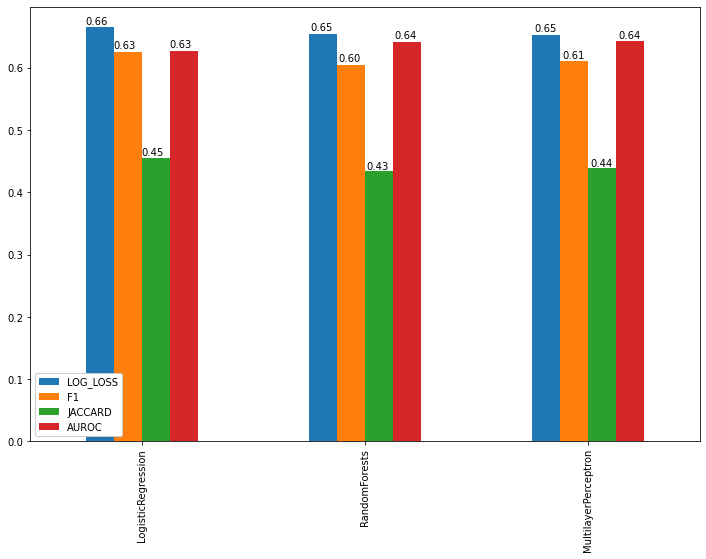

In [29]:
ax = best_scores_df.plot(kind="bar",width=0.5,figsize=(12,8))
for p in ax.patches:
    ax.annotate("{:.2f}".format(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.008))
ax.legend(loc="lower left",framealpha=1)

The table of metrics shows that both the Logistic Regression Classifier (LRC) and the Multilayer Perceptron (MLP) perform better than the Random Forest Classifier. The table also tells us that the LRC has the best values for the F1 and Jaccard similarity index, where as the MLP has the best values for logarithmic loss and AUROC. 

In order to choose the overall best performing model for this particular problem we need to know what the goal of this project is. We are interested in the probabilities of the classes of the accident severity and as such we have to choose the MLP as our best performing classifier. 

However, that is not to say that it has performed very well. With a logarithmic loss of $0.65 $ and AUROC $0.64 > 0.5$, the model can indeed classify the severity correctly, though not with a high precision. There are a number of reasons why this is the case, but only on is the most important.

All vehicles are driven by humans and therefore the most likely cause for car accidents and their severity is human error, which is not quantifiable. It is also by chance, it is random. The severity's dependence on the features lies in the fact that those factors affect the chance for human error occuring. This model can only do so much at predicting the randomness that is involved in a car accident.



## Conclusion <a name= "conclusion"></a>

In this study we attempted to create a machine learning model which predicts the severity of a car accident based on a few environmental factors and locational information. We achieved a minimum logarithmic loss of $0.65 (2dp)$ and an area under ROC of $0.64 (2dp)$. Considering our goal, this study has been an overall success. We created a model which can predict, though not extremely well, the severity of a car accident using just 4 features. What makes this even more of a success, is the fact that the most likely factor which influences an accident's severity is human error. It is not quantifiable and the 4 features which we built our model upon only affect the probability of human error occurring.